In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from sklearn.model_selection import train_test_split
from csv import DictWriter
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import sem
import pandas as pd
import matplotlib.pyplot as plt

from calc_prediction_accuracy import get_accuracy



In [13]:
# Fit a slope to the data
def model_lin_reg(time, distance, weights = None):
    time = np.array(time)
    x_segment = np.array(time).reshape(-1, 1)
    y_segment = np.array(distance).reshape(-1, 1)

    model = LinearRegression(fit_intercept=False)
    model.fit(x_segment, y_segment, weights)
    slope = (model.coef_[0])

    ypred = model.predict(x_segment)
    mse = mean_squared_error(distance, ypred)
    return slope, mse, model

def calculate_testing(mean_slope, testing_data):
    print(testing_data)
    print(type(testing_data))

# Load the data from the uploaded CSV file
# As the delimiter is specified as ';', we'll use that to read the CSV
basepath = Path("C:/Users/n3xed/OneDrive - OST/Hackathon 2023")

weisglas_path = basepath / 'fuellstandsensoren-glassammelstellen-weissglas-processed.csv'
braunglas_path = basepath / 'fuellstandsensoren-glassammelstellen-braunglas-processed.csv'
grunglas_path = basepath / 'fuellstandsensoren-glassammelstellen-gruenglas-processed.csv'



In [16]:

results = {}

for glass_type in ["weisglas","braunglas","grunglas"]:
    if glass_type == "weisglas":
        path = weisglas_path
    elif glass_type == "braunglas":
        path = braunglas_path
    elif glass_type == "grunglas":
        path = grunglas_path
    else:
        raise NotImplementedError()
    data = pd.read_csv(path, delimiter=',')
    data = data.sort_values(by='timestamp')
    counter = 0
    result_mse = {}
    result_slope = {}
    result_slope_list = []
    
    results[glass_type] = {}

    for group, collection_point in data.groupby("name"):
        results[glass_type][group] = {}

        group_max = collection_point["distance"].max()
        
        # The original data is the distance from the sensor to the top of the glass
        # we want to have a normalized value between 0 and 1, where 0 is empty and 1 is full.
        collection_point["distance"] = collection_point["distance"].apply(lambda v: 1 - v/group_max)
        combined_data = collection_point.groupby("period")[["timestamp","distance"]].agg(list)
        
        # For some reason all periods have a slightly different y offset; remove it so
        # that all periods start at 0.
        # A period is a single fill-up of the glass container.
        combined_data["distance"] = combined_data["distance"].apply(lambda v: np.array(v) - np.min(v))

        # Split the data into training and test data
        training_data, test_data = train_test_split(combined_data, test_size=0.2, shuffle=False)

        # Calculate the mean period length in days
        period_lengths = []
        for index, period_data in training_data.iterrows():
            period_lengths.append(period_data["timestamp"][-1] - period_data["timestamp"][0])
        mean_period_length = np.array(period_lengths).mean() / (24 * 3600)
        results[glass_type][group]["mean_period_length"] = mean_period_length
        
        # Aggregate all periods into one bin of data where the first sample of every period is at t=0.
        agg_times = []
        agg_dists= []
        agg_weights = []
        for index, period_data in training_data.iterrows():
            agg_times.extend(np.array(period_data["timestamp"]) - np.min(period_data["timestamp"]))
            agg_dists.extend(period_data["distance"])
            
            n = agg_times[-1] / (24 * 3600)
            u = mean_period_length
            sigma = 10
            w = np.exp(-0.5*((n-u)/sigma)**2)
            agg_weights.extend([w]*len(period_data["timestamp"]))
        
        # Fit the slope.
        mean_slope, mean_mse, model = model_lin_reg(agg_times, agg_dists, agg_weights)
        result_mse[group] = mean_mse
        result_slope[group] = mean_slope
        
        results[glass_type][group]["test_data"] = test_data
        results[glass_type][group]["train_data"] = training_data
        results[glass_type][group]["mean_slope"] = mean_slope

        rse, rsq = get_accuracy(mean_slope, test_data)
        
        # Save the sensor name and the slope in fullness per day to a CSV file.
        result_slope_list.append({
            "name": group,
            "slope (fullness/day)": float(mean_slope * (24*3600)),
            "mse": float(mean_mse),
            "test_rse": rse,
            "r_squared": rsq
        })
                                 
        results[glass_type][group]["rse"] = rse
        print(f"{group}: RSE={float(rse):.5f}, R_Sq={float(rsq):.5f}, MSE={float(mean_mse):.5f}, slope={float(mean_slope*24*3600):.5f}")

    with open(f"{glass_type}_slopes.csv", "w", newline="") as w:
        dict_writer = DictWriter(w, ["name","slope (fullness/day)","mse","test_rse","r_squared"])
        dict_writer.writeheader()
        dict_writer.writerows(result_slope_list)
        

104244: RSE=1.27382, R_Sq=0.76553, MSE=0.00901, slope=0.07693
104250: RSE=3.26027, R_Sq=0.46399, MSE=0.00510, slope=0.02680
107040 | 8572: RSE=3.49779, R_Sq=0.60557, MSE=0.00256, slope=0.03814
107047 | 0D1A: RSE=1.05235, R_Sq=0.84285, MSE=0.33618, slope=0.04954
107049 | 4B00: RSE=1.77036, R_Sq=0.65097, MSE=0.00933, slope=0.04304
107058 | 282C: RSE=1.73083, R_Sq=0.86124, MSE=0.00264, slope=0.02757
107062 | 49A3: RSE=1.71286, R_Sq=0.33551, MSE=0.00475, slope=0.06217
107064 | 4B16: RSE=1.55258, R_Sq=0.48711, MSE=0.00481, slope=0.06763
107065 | 4A3D: RSE=1.46092, R_Sq=0.88596, MSE=0.00397, slope=0.04395
107066 | 0F09: RSE=1.05340, R_Sq=0.94234, MSE=0.00278, slope=0.03369
107072 | F389: RSE=0.72989, R_Sq=0.85299, MSE=0.00622, slope=0.05800
107075 | 2B2A: RSE=2.98741, R_Sq=0.35012, MSE=0.00650, slope=0.01713
107095 | 64BC: RSE=1.24480, R_Sq=0.00831, MSE=0.00622, slope=0.12240
107098 | 0DE6: RSE=1.06914, R_Sq=0.86901, MSE=0.00196, slope=0.03257
107113 | F502: RSE=0.82663, R_Sq=0.85387, MSE=0.

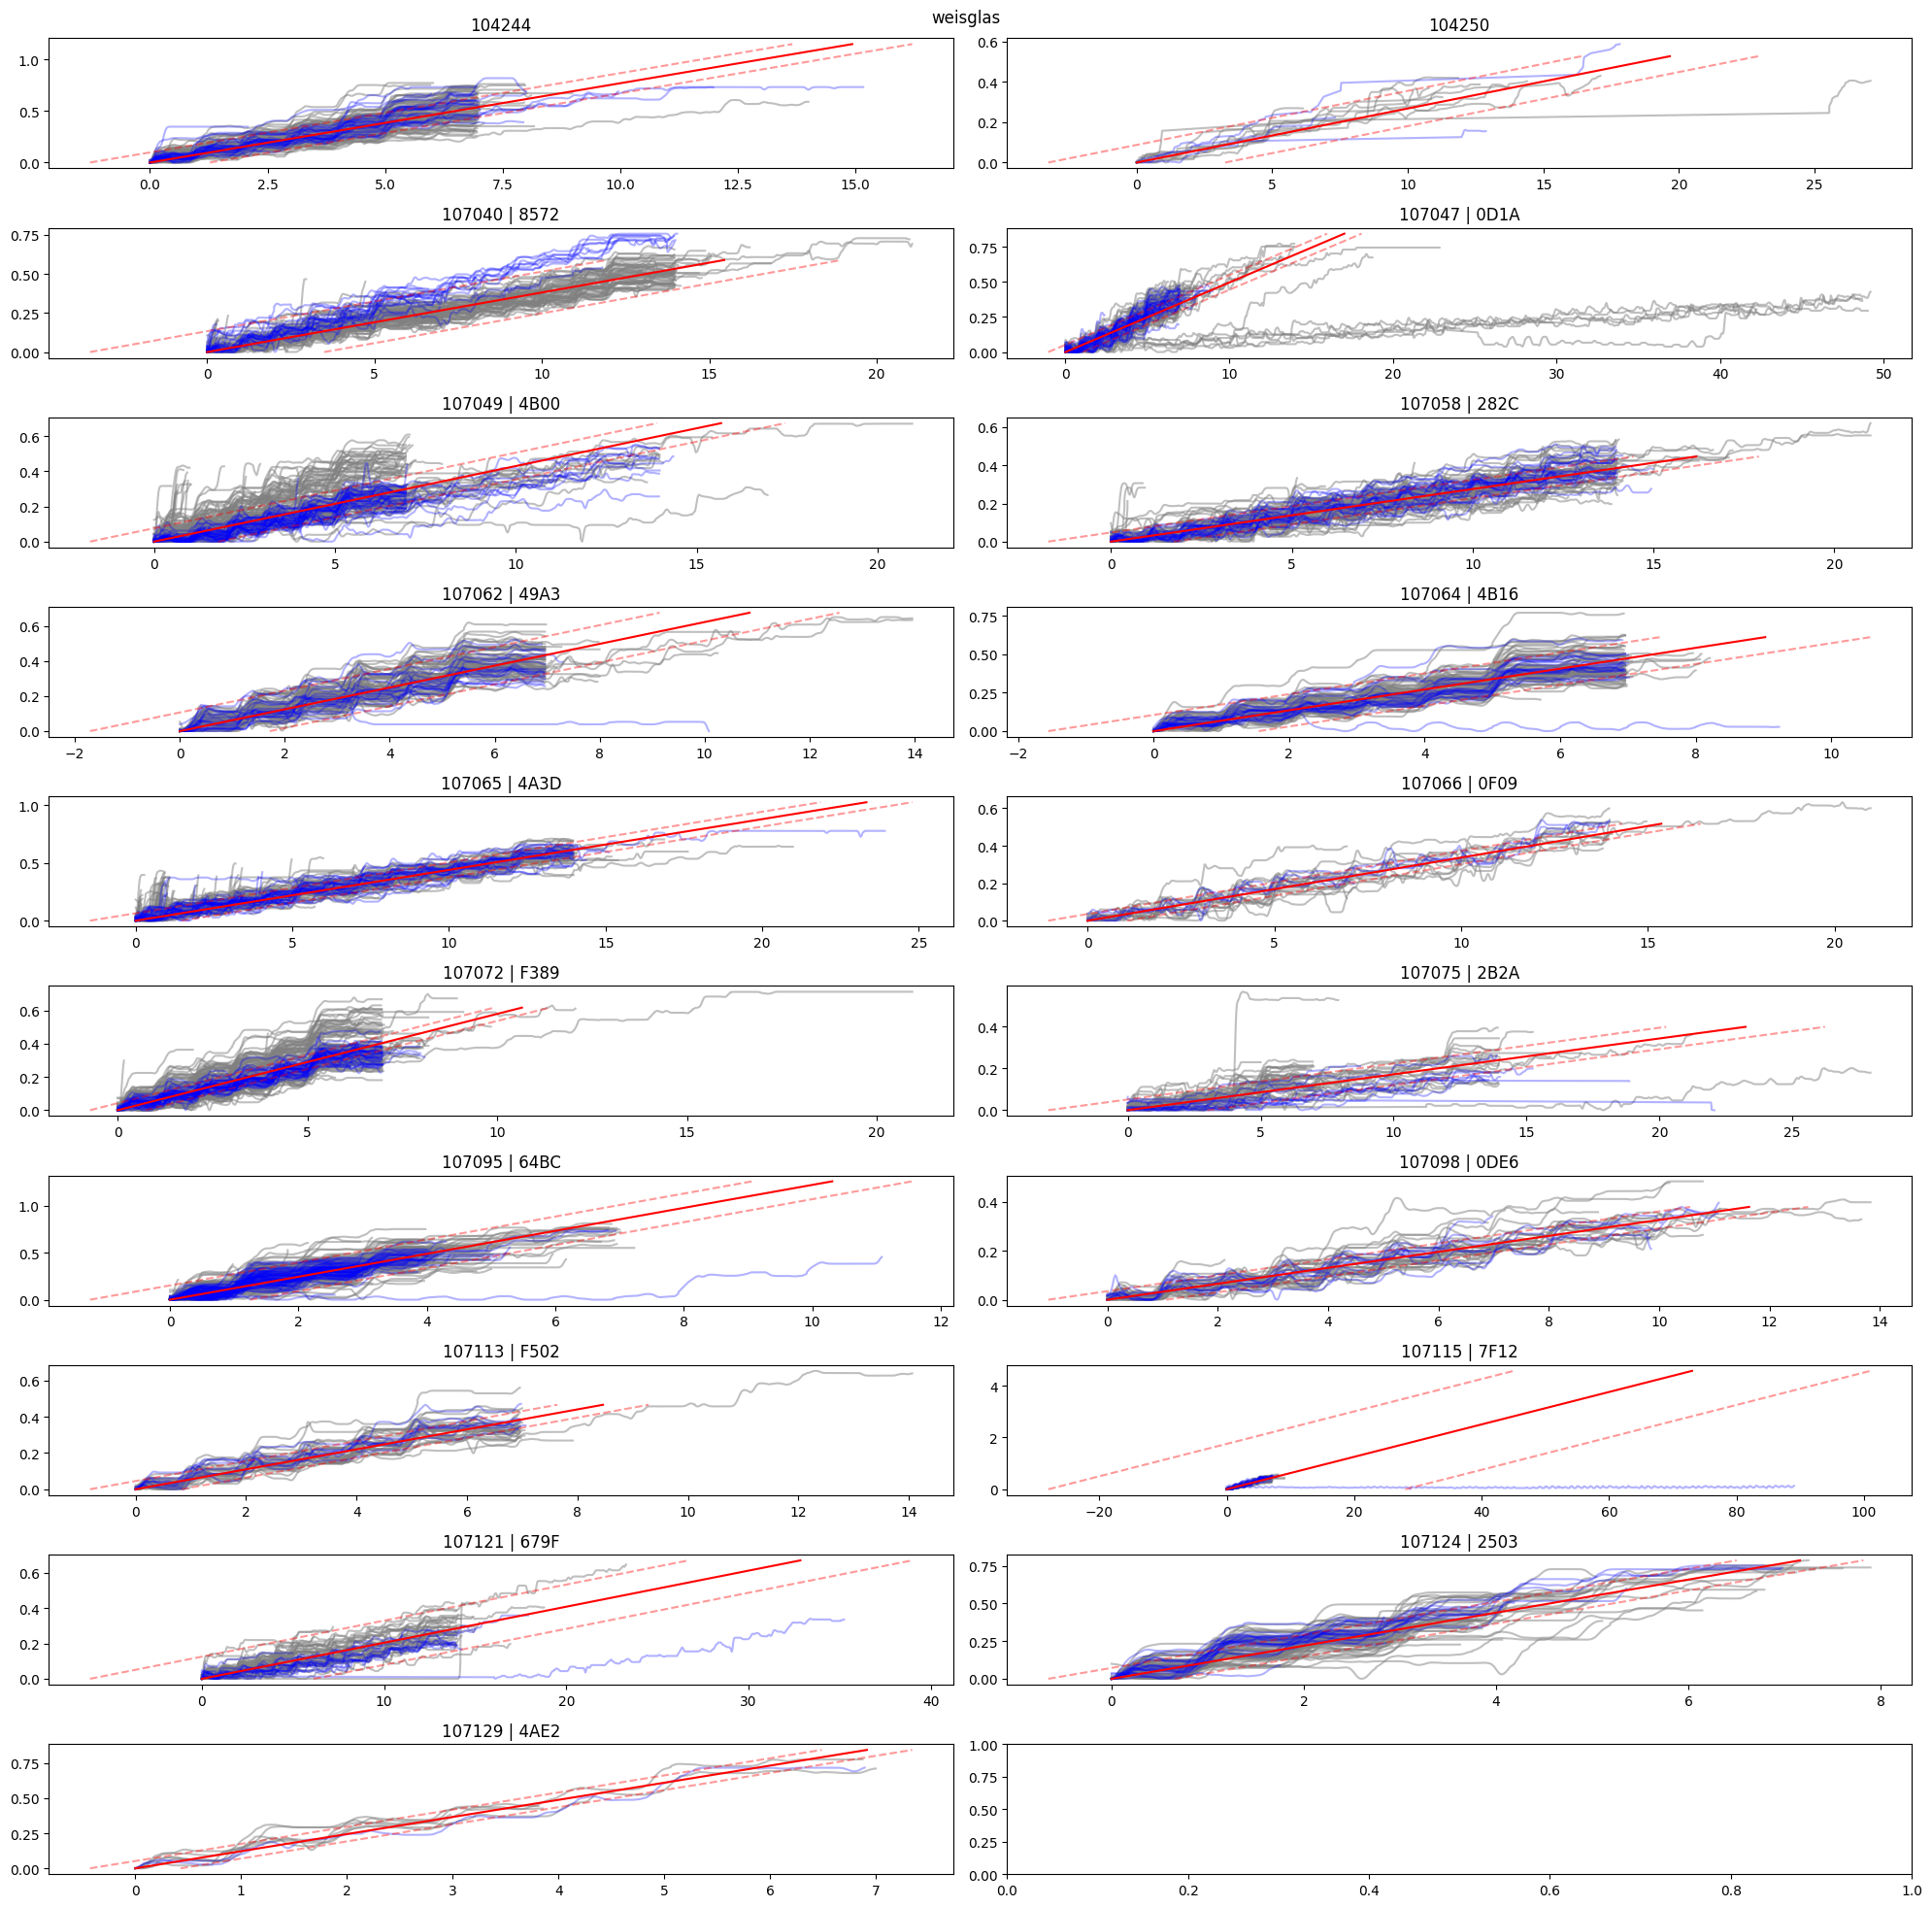

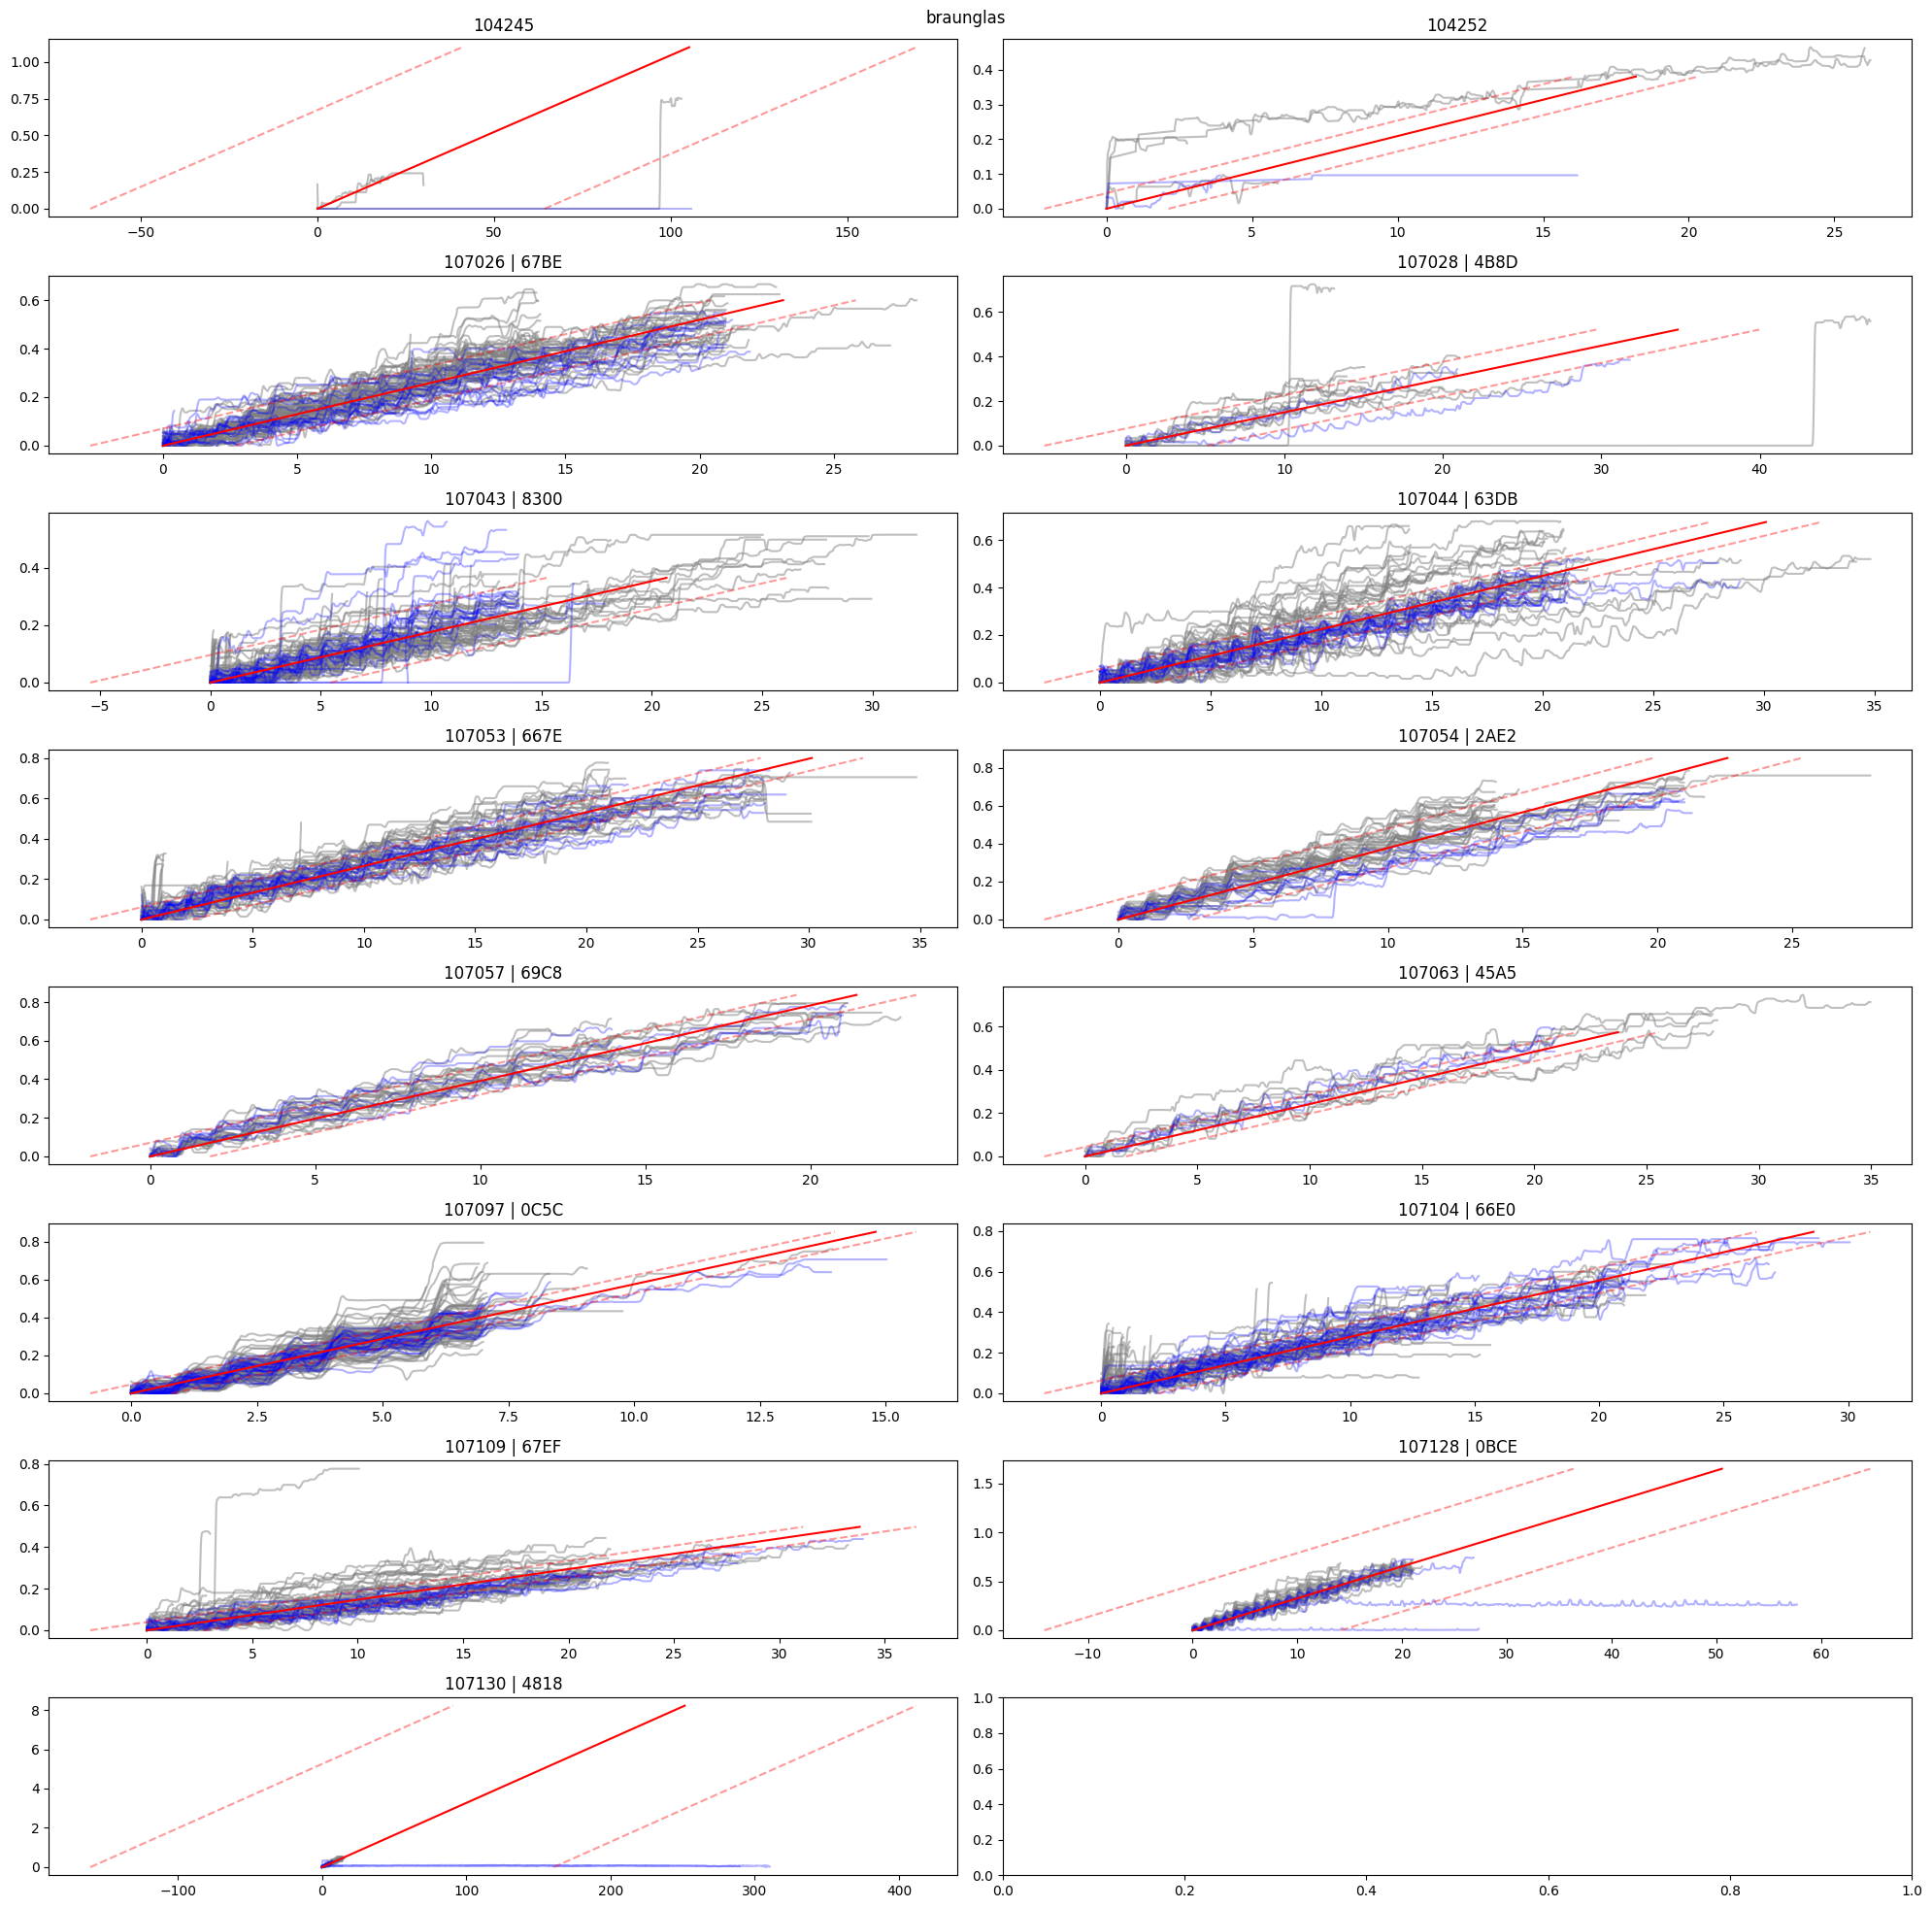

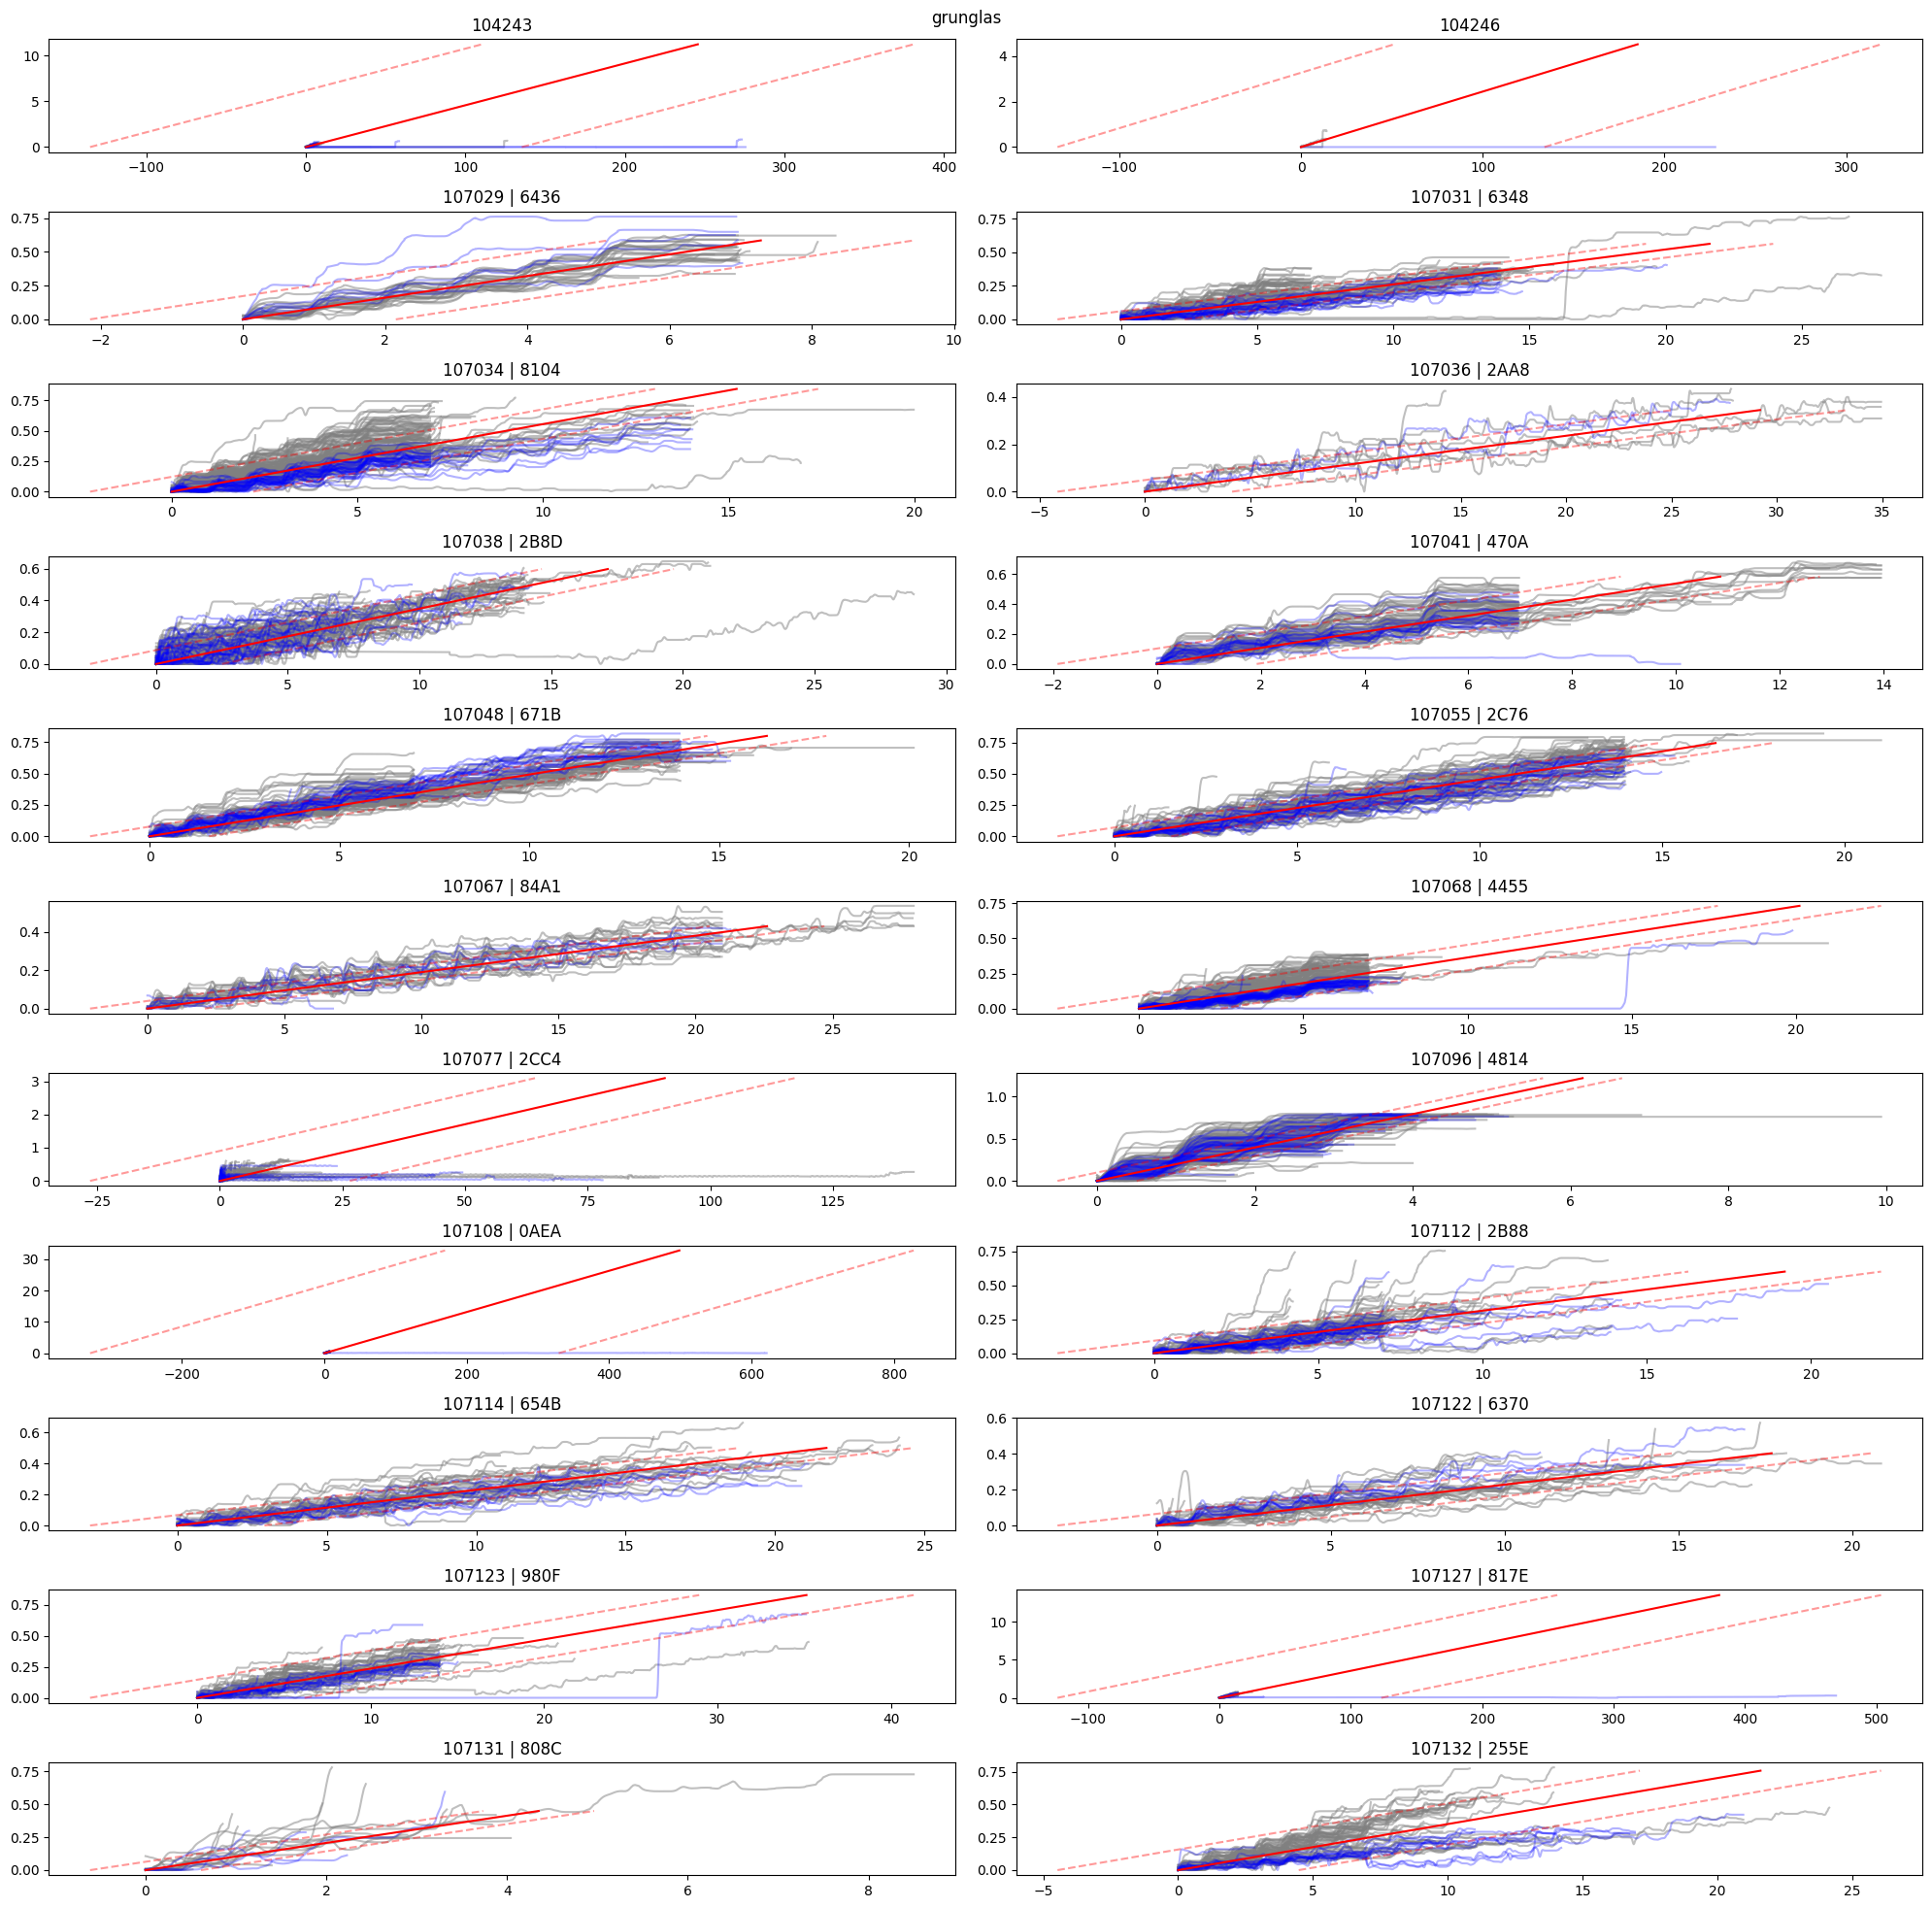

In [17]:
# Draw a plot for each glass type, the plot contains the training data in gray,
# the test data in blue and the prediction in red.
# The x axis is the time in days since the container was emptied. The y axis is
# the fill level of the container where 0 is empty and 1 is full.
for glass_type, glass_data in results.items():
    nrows = round(len(glass_data)/2.0)

    fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(20, 20))
    fig.set_tight_layout(True)
    fig.suptitle(f"{glass_type}")
    axs = axs.flatten()
    for i, (name, data) in enumerate(glass_data.items()):
        train_data = data["train_data"]
        test_data = data["test_data"]
        mean_slope = data["mean_slope"] * 24 * 3600

        train_timestamps = [np.array(l) - l[0] for l in train_data["timestamp"]]
        train_dists = [np.array(l) for l in train_data["distance"]]
        
        timestamps =  [np.array(l) - l[0] for l in test_data["timestamp"]]
        dists = [np.array(l) for l in test_data["distance"]]
        
        last_train_timestamp = 0
        
        for train_timestamp, train_dist in zip(train_timestamps[::1], train_dists[::1]):
            last_train_timestamp = max(last_train_timestamp, train_timestamp[-1])
            axs[i].plot(train_timestamp / (24 * 3600), train_dist, label="train", color="grey", alpha=0.5)
        
        axs[i].set_title(f"{name}")
        
        last_timestamp = 0
        for timestamp, dist in zip(timestamps, dists):
            last_timestamp = max(last_timestamp, timestamp[-1])
            axs[i].plot(timestamp / (24 * 3600), dist, color="blue", alpha=0.3)
            
        # Calculate a nice final time for the prediction.
        pred_time = np.array([0.0, last_timestamp*0.8 + last_train_timestamp*0.2]) / (24 * 3600)

        # Plot the slope of the prediction.
        axs[i].plot(pred_time, (mean_slope)*pred_time, label="predicted", color="red")
        rse = data["rse"]
        axs[i].plot(pred_time - rse, (mean_slope)*pred_time, label="predicted + rse", color="red", linestyle="--", alpha=0.4)
        axs[i].plot(pred_time + rse, (mean_slope)*pred_time, label="predicted - rse", color="red", linestyle="--", alpha=0.4)